# Implementation of "Discovering Interpretable Directions in the Semantic Latent Space of Diffusion Models"

Paper: https://arxiv.org/pdf/2303.11073.pdf

This is an inofficial implementation. Not all the details are correct, especially for section 2.

## Setup

In [1]:
from diffusers import DiffusionPipeline
import torch
from sklearn.decomposition import PCA
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
# load pipeline/model
pipeline = DiffusionPipeline.from_pretrained("google/ddpm-ema-celebahq-256").to('cuda')
pipeline.set_progress_bar_config(disable=True)
print(f'Number of parameters: {sum(p.numel() for p in pipeline.unet.parameters())}')

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Number of parameters: 113673219


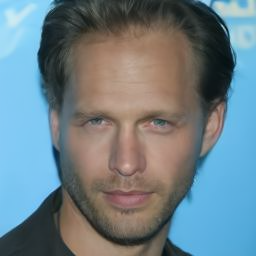

In [3]:
# sample image
pipeline(num_inference_steps = 50).images[0]

In [4]:
# check h-space shape
h_space = []
def get_h_space(module, input, output):
    h_space.append(output.cpu())
with torch.no_grad(), pipeline.unet.mid_block.register_forward_hook(get_h_space):
    pipeline.unet(torch.randn(1, 3, 256, 256).cuda(), 1)
print(f'h-space shape: {tuple(h_space[0].shape[1:])}')

h-space shape: (512, 8, 8)


In [21]:
def plot_image_grid(n_rows: int, modification: Callable[[int, int], torch.Tensor], seed = None, row_labels: list[str] = []):
    '''plot grid of images generated with modifications'''

    # setup
    factors = [-2, -1, 0, 1, 2]
    fig, axarr = plt.subplots(n_rows, 5, figsize=(10, 2*n_rows), squeeze=False)
    if seed is None: seeds =  [x.item() for x in torch.randint(0, 100000, (n_rows,))]
    elif isinstance(seed, int): seeds = [seed] * n_rows
    elif isinstance(seed, list): seeds = seed
    else: raise ValueError('seed must be int, list or None')
    progress = tqdm(total=5*n_rows, desc='Generating images')

    # make image grid
    for j in range(n_rows):
        seed = seeds[j]
        for i, factor in enumerate(factors):

            # generate image with modification
            def modify_h_space(module, input, output, step=[0]):
                change = factor * modification(j, step[0])
                step[0] += 1
                return output + change
            with torch.no_grad(), pipeline.unet.mid_block.register_forward_hook(modify_h_space):
                image = pipeline(num_inference_steps=50, generator=torch.Generator("cuda").manual_seed(seed)).images[0]

            # plot
            axarr[j, i].imshow(image)
            axarr[j, i].set_yticklabels([])
            axarr[j, i].set_xticklabels([])
            axarr[j, i].set_xticks([])
            axarr[j, i].set_yticks([])
            for key, spine in axarr[j, i].spines.items(): spine.set_visible(False)
            progress.update(1)

    # finish up
    for i, f in enumerate(factors):
        axarr[0, i].set_title(f'{f}' if f != 0 else 'original')
    for i, label in enumerate(row_labels):
        axarr[i, 0].set_ylabel(label)
    progress.close()
    plt.tight_layout()
    plt.show()

## 1. Global semantic directions - PCA

In [16]:
# config
n_components = 5  # number of principal components to analyze
batch_size = 20  # adjust based on your GPU memory
n_batches = 20  # number of batches for PC generation
pc_scaling = 200  # scaling factor for principal components

In [7]:
def extract_h_spaces():
    '''extract h-space representations for use in PCA'''
    h_space = []
    def get_h_space(module, input, output):
        h_space[-1].append(output.cpu())
    with torch.no_grad(), pipeline.unet.mid_block.register_forward_hook(get_h_space):
        for i in trange(n_batches, desc = 'Extracting h-space batches'):
            h_space.append([])
            pipeline(num_inference_steps=50, batch_size=batch_size)
    h_space = torch.cat([torch.stack(x, dim=1) for x in h_space])
    return h_space.view(-1, 50*512*8*8).numpy()

# get PCs
pca = PCA(n_components=n_components)
pca.fit(extract_h_spaces())
pcs = torch.tensor(pca.components_.reshape(-1, 50, 512, 8, 8)).cuda()

Extracting h-space batches:   0%|          | 0/20 [00:00<?, ?it/s]

Generating images:   0%|          | 0/25 [00:00<?, ?it/s]

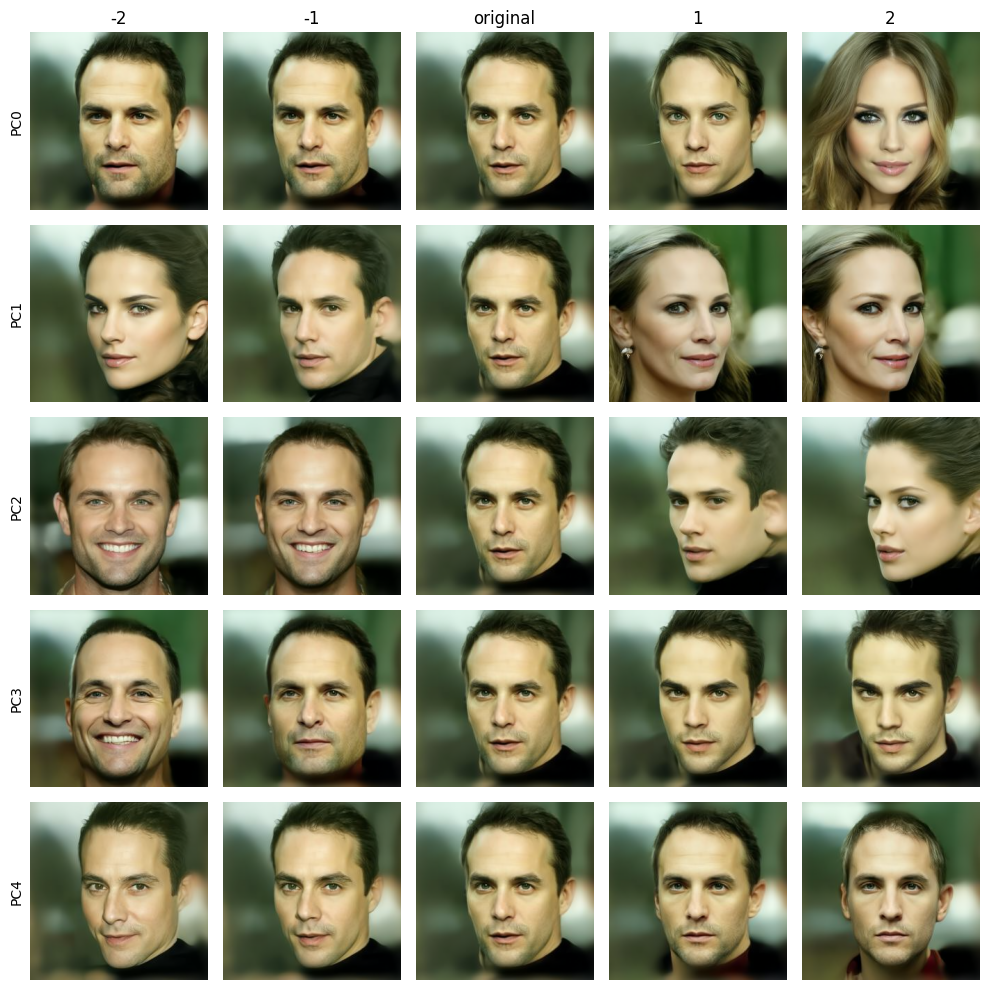

In [17]:
plot_image_grid(
    n_rows = n_components,
    modification = lambda row, step: pcs[row,step,:,:,:] * pc_scaling,
    seed = torch.randint(0, 100000, (1,)).item(),
    row_labels = [f'PC{i}' for i in range(n_components)]
)

## 2. Discovering image-specific semantic edits

Compared to the paper, this implementation only finds the one direction in h-space that induces the largest change and doesn't use power iteration.

In [13]:
# calculate gradients
def calc_gradients(seed=0):
    generator = torch.Generator("cuda").manual_seed(seed)
    change = torch.zeros(1, 512, 8, 8, device='cuda', requires_grad=True)
    pipeline.unet.eval()
    gradients = []
    def get_h_space(module, input, output):
        change.requires_grad_(True)
        return change + output
    def get_output(module, input, output):
        gradients.append(torch.autograd.grad(output.abs().sum(), change)[0].cpu())
        change.requires_grad_(False)
        return output.detach()
    with pipeline.unet.mid_block.register_forward_hook(get_h_space), pipeline.unet.conv_out.register_forward_hook(get_output):
        image = torch.randn(1, 3, 256, 256, generator=generator, device='cuda')
        pipeline.scheduler.set_timesteps(50)
        for t in tqdm(pipeline.scheduler.timesteps):
            model_output = pipeline.unet(image, t).sample
            image = pipeline.scheduler.step(model_output, t, image, generator=generator).prev_sample
    return torch.stack(gradients)

base_seed = 42  # seed for the base image
gradients = calc_gradients(base_seed)

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images:   0%|          | 0/15 [00:00<?, ?it/s]

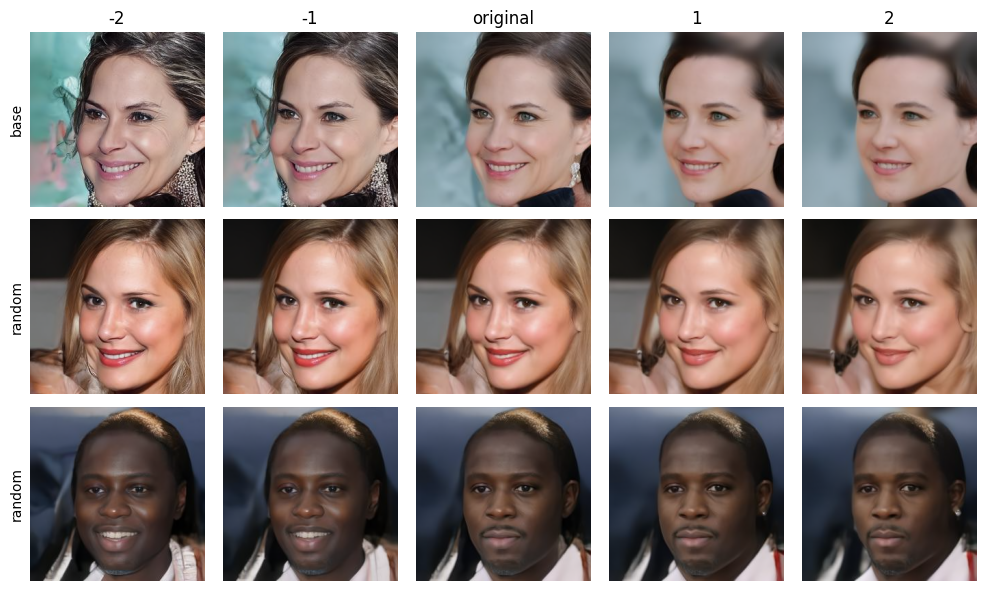

In [15]:
# config
num_rows = 3  # number of rows to plot, i.e. number of random seeds
grad_scaling = 2  # scaling factor for gradients
time_step = 25  # time step to analyze

# plot
avg_gradient = gradients[time_step].cuda()
plot_image_grid(
    n_rows = num_rows,
    modification = lambda row, step: avg_gradient * grad_scaling,
    seed = [base_seed] + [x.item() for x in torch.randint(0, 100000, (num_rows-1,))],
    row_labels = ['base'] + ['random']*(num_rows-1)
)

## 3. Supervised discovery of semantic directions

8253


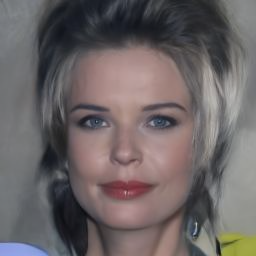

In [18]:
# call this cell repeatedly to find seeds for specific attributes
seed = torch.randint(0, 100000, (1,)).item()
print(seed)
pipeline(num_inference_steps=50, generator=torch.Generator("cuda").manual_seed(seed)).images[0]

In [19]:
# input seeds
smile_examples = [38857, 16253, 37662, 56450, 16339, 52828, 22733, 26428, 6047]
no_smile_examples = [19619, 14745, 80897, 51023, 55300, 5574, 34912, 65653, 70070]

# smile direction
def seed2hspace(seed):
    h_space = []
    def get_h_space(module, input, output):
        h_space.append(output)
    with torch.no_grad(), pipeline.unet.mid_block.register_forward_hook(get_h_space):
        pipeline(num_inference_steps=50, generator=torch.Generator("cuda").manual_seed(seed))
    return torch.cat(h_space)
avg_smile = torch.stack([seed2hspace(seed) for seed in tqdm(smile_examples)]).mean(dim=0)
avg_no_smile = torch.stack([seed2hspace(seed) for seed in tqdm(no_smile_examples)]).mean(dim=0)
smile_direction = avg_smile - avg_no_smile

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Generating images:   0%|          | 0/15 [00:00<?, ?it/s]

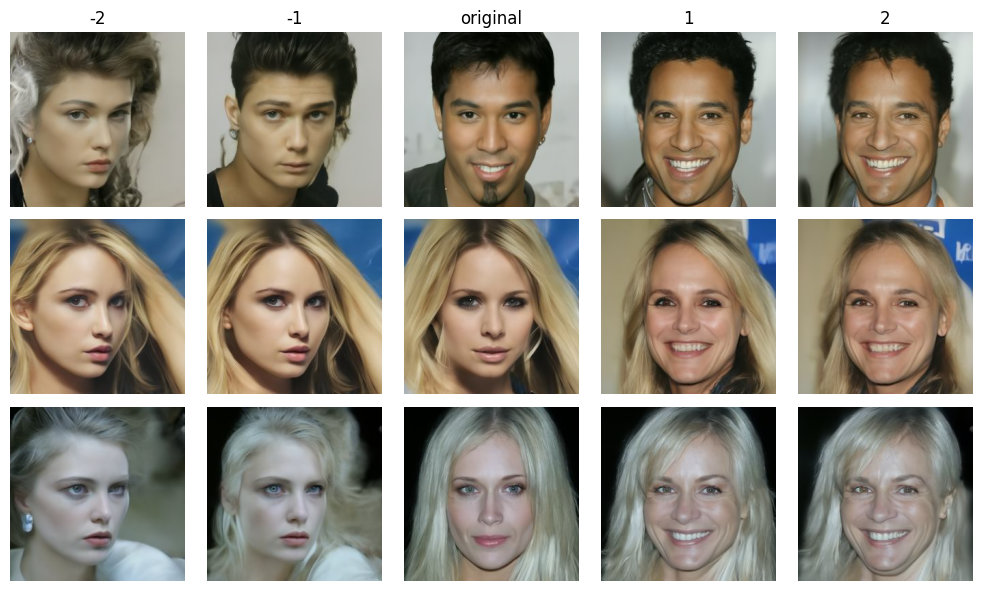

In [23]:
plot_image_grid(
    n_rows = 3,
    modification = lambda row, step: smile_direction[step],
)